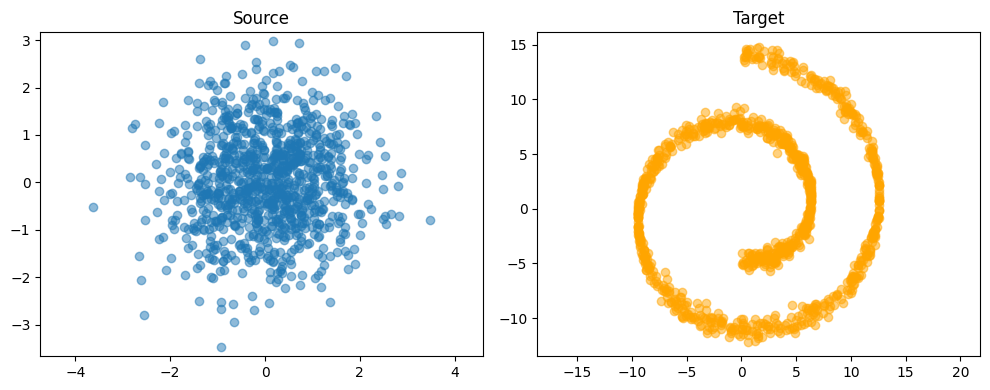

In [49]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchdiffeq import odeint


# 2. Data Generation (shared)


def sample_standard_gaussian(n_samples=1000):
    return np.random.randn(n_samples, 2).astype(np.float32)

def sample_swiss_roll(n_samples=1000):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
    x = t * np.cos(t)
    y = t * np.sin(t)
    noise = 0.5 * np.random.randn(n_samples)
    return np.stack([x, y + noise], axis=1).astype(np.float32)

def sample_star_distribution(n_samples=1000, arms=5):
    angles = np.random.choice(np.linspace(0, 2*np.pi, arms, endpoint=False), n_samples)
    r = 2 + 0.3 * np.random.randn(n_samples)
    x = r * np.cos(angles) + 0.1 * np.random.randn(n_samples)
    y = r * np.sin(angles) + 0.1 * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_gaussian_mixture(n_samples=1000):
    centers = [np.array([-2.0, 0.0]), np.array([2.0, 0.0])]
    samples = []
    for _ in range(n_samples):
        center = centers[np.random.choice([0, 1])]
        noise = np.random.randn(2) * 0.2
        samples.append(center + noise)
    return np.array(samples, dtype=np.float32)

source_np = sample_standard_gaussian(1000)
target_np = sample_swiss_roll(1000)
# target_np = sample_gaussian_mixture(1000)
# source_np = sample_swiss_roll(1000)
# target_np = sample_standard_gaussian(1000)

# Visualize source and target samples
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(source_np[:, 0], source_np[:, 1], alpha=0.5)
plt.title("Source")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(target_np[:, 0], target_np[:, 1], alpha=0.5, color='orange')
plt.title("Target")
plt.axis("equal")

plt.tight_layout()
plt.show()

In [50]:
# Re-import after kernel reset
from scipy.linalg import sqrtm
from scipy.stats import wasserstein_distance

# Redefine metrics
def frechet_distance(X_gen, X_real):
    mu_gen = np.mean(X_gen, axis=0)
    mu_real = np.mean(X_real, axis=0)
    cov_gen = np.cov(X_gen, rowvar=False)
    cov_real = np.cov(X_real, rowvar=False)
    covmean = sqrtm(cov_gen @ cov_real)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu_gen - mu_real
    return diff @ diff + np.trace(cov_gen + cov_real - 2 * covmean)

def wasserstein_2d(X_gen, X_real):
    d1 = wasserstein_distance(X_gen[:, 0], X_real[:, 0])
    d2 = wasserstein_distance(X_gen[:, 1], X_real[:, 1])
    return (d1 + d2) / 2


In [51]:
# Convert to Torch tensors
source_data = torch.tensor(source_np)
target_data = torch.tensor(target_np)
dataset = TensorDataset(source_data, target_data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)


In [52]:
# 4. CNF (ODE-based Flow)
class CNFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

# 6. CNF Training (Log-likelihood Based)

# Helper: log probability of standard Gaussian

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

# CNF with Hutchinson trace estimation
def trace_df_dx(f, x, t):
    e = torch.randn_like(x)  # random vector for Hutchinson estimator
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=100, lr=1e-3, batch_size=256, method="rk4"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_samples)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=x_T.device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=x_T.device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method, options={"step_size": 0.1}, atol=1e-5, rtol=1e-5)

            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")

# 7. Visualization
def sample_from_cnf(model, n_samples=1000):
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 2)

        def odefunc(t, x):
            return model(t, x)

        t0, t1 = 0.0, 1.0
        t_vals = torch.tensor([t0, t1], dtype=z0.dtype, device=z0.device)
        out = odeint(odefunc, z0, t_vals)
        xT = out[1]  # take the final result
        return xT
            
def visualize_cnf(model, n_samples=1000):
    x0 = torch.tensor(sample_standard_gaussian(n_samples))
    t_vals = torch.linspace(0, 1, 20)

    with torch.no_grad():
        cnf_trajectory = odeint(model, x0, t_vals)

    cnf_generated = sample_from_cnf(model).numpy()

    fig, axes = plt.subplots(1, len(t_vals)//4 + 1, figsize=(18, 3))
    for i, t_idx in enumerate(range(0, len(t_vals), 4)):
        axes[i].scatter(cnf_trajectory[t_idx][:, 0], cnf_trajectory[t_idx][:, 1], alpha=0.4, color='orange')
        axes[i].set_title(f"CNF t={t_vals[t_idx]:.2f}")
    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(cnf_generated[:, 0], cnf_generated[:, 1], alpha=0.3, label="CNF", color='orange')
    axes[-1].legend()
    axes[-1].set_title("CNF Gen vs Target")
    plt.tight_layout()
    plt.show()
    
    fd_cnf = frechet_distance(cnf_generated, target_np)
    wd_cnf = wasserstein_2d(cnf_generated, target_np)
    print('The frechet distance of CNF model is: ', fd_cnf)
    print('The wasserstein distance of CNF model is: ', wd_cnf)

In [53]:
def train_cnf_with_reflow(model, epochs=20, batch_size=256, lr=1e-3, n_samples=1000, method="rk4"):
    """
    Perform one round of Reflow-style CNF training:
    1. Use the current CNF model to generate pseudo target points x1_hat.
    2. Train the model to map z0 → x1_hat using log-likelihood loss.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    # Step 1: Generate pseudo target points using the current CNF
    with torch.no_grad():
        z0 = torch.randn(n_samples, 2)
        t_vals = torch.tensor([0.0, 1.0])
        x1_hat = odeint(model, z0, t_vals, method=method)[-1]

    # Step 2: Build a dataset of (z0, x1_hat) pairs
    dataset = TensorDataset(z0, x1_hat)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Step 3: Train CNF using log-likelihood objective on pseudo pairs
    for epoch in range(epochs):
        for z, x1 in loader:
            x1 = x1.clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x1.shape[0])

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            (z_out, delta_logp) = odeint(odefunc, (x1, logp_T), torch.tensor([1.0, 0.0]), method=method)

            logp_0 = standard_normal_logprob(z_out[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            print(f"[Reflow-CNF] Epoch {epoch} | NLL: {loss.item():.4f}")

    return model


Training Continuous Normalizing Flow...
[CNF] Epoch 0 | NLL: 46.9782
[CNF] Epoch 10 | NLL: 20.3166
[CNF] Epoch 20 | NLL: 10.5997
[CNF] Epoch 30 | NLL: 9.3689
[CNF] Epoch 40 | NLL: 8.1879
[CNF] Epoch 50 | NLL: 7.4212
[CNF] Epoch 60 | NLL: 7.2469
[CNF] Epoch 70 | NLL: 6.8744
[CNF] Epoch 80 | NLL: 6.5312
[CNF] Epoch 90 | NLL: 6.4888
[CNF] Epoch 100 | NLL: 6.4056
[CNF] Epoch 110 | NLL: 6.2117
[CNF] Epoch 120 | NLL: 6.2743
[CNF] Epoch 130 | NLL: 6.2010
[CNF] Epoch 140 | NLL: 6.2034
[CNF] Epoch 150 | NLL: 6.1855
[CNF] Epoch 160 | NLL: 6.1698
[CNF] Epoch 170 | NLL: 6.1748
[CNF] Epoch 180 | NLL: 6.1444
[CNF] Epoch 190 | NLL: 6.0966
[CNF] Epoch 200 | NLL: 6.1036
[CNF] Epoch 210 | NLL: 5.9066
[CNF] Epoch 220 | NLL: 5.9027
[CNF] Epoch 230 | NLL: 5.9754
[CNF] Epoch 240 | NLL: 6.0502
[CNF] Epoch 250 | NLL: 5.9618
[CNF] Epoch 260 | NLL: 5.8412
[CNF] Epoch 270 | NLL: 5.8459
[CNF] Epoch 280 | NLL: 5.8418
[CNF] Epoch 290 | NLL: 5.8680
[CNF] Epoch 300 | NLL: 5.7741
[CNF] Epoch 310 | NLL: 5.6563
[CNF] Ep

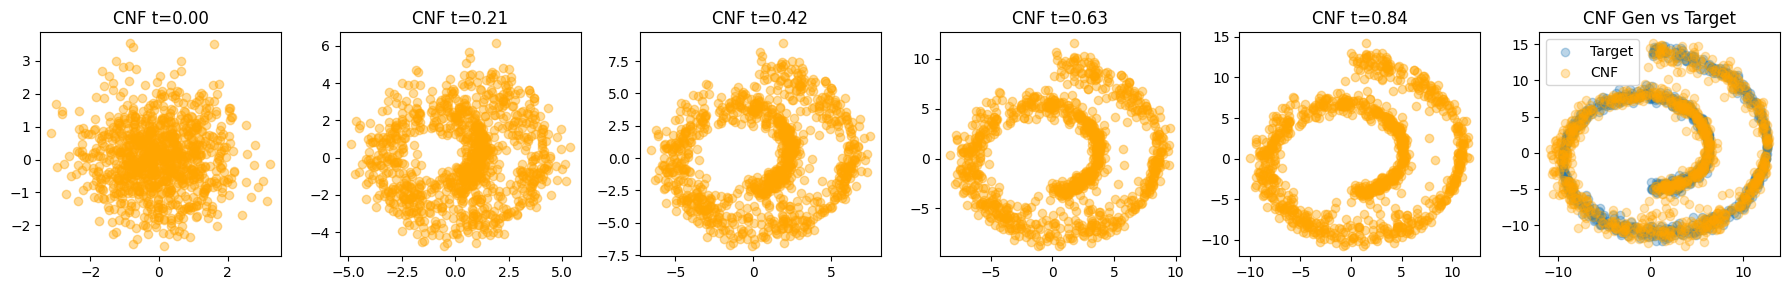

The frechet distance of CNF model is:  0.4678456005501914
The wasserstein distance of CNF model is:  0.4037066250061616


In [54]:
# 8. Main Execution
import time
import psutil
import os
import tracemalloc
import torch.cuda
if __name__ == "__main__":
    # Initialize models
    cnf_model = CNFNet()



    print("Training Continuous Normalizing Flow...")
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    train_cnf(cnf_model, target_data, epochs= 500)
    cnf_time = time.time() - start_time
    print(cnf_time)



    # Visualize learned transformations
    visualize_cnf(cnf_model)
    
    



[Reflow-CNF] Epoch 0 | NLL: 5.3047
[Reflow-CNF] Epoch 5 | NLL: 5.1675
[Reflow-CNF] Epoch 10 | NLL: 4.9922
[Reflow-CNF] Epoch 15 | NLL: 4.7883
[Reflow-CNF] Epoch 20 | NLL: 4.8847
[Reflow-CNF] Epoch 25 | NLL: 4.8502


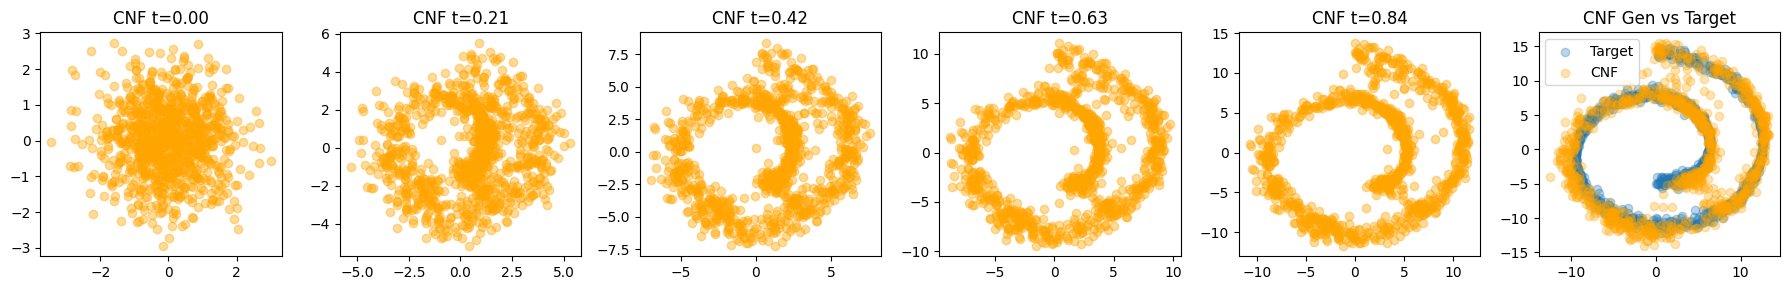

The frechet distance of CNF model is:  0.9435284289219794
The wasserstein distance of CNF model is:  0.5698647630987688


In [55]:
trained_model = train_cnf_with_reflow(cnf_model, epochs=30)
visualize_cnf(trained_model)